In [1]:
# Imports

# pandas
import pandas as pd
from pandas import Series,DataFrame
from pandas.tools.plotting import scatter_matrix

# numpy, matplotlib, seaborn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.metrics import confusion_matrix
from sklearn import cross_validation
from sklearn.cross_validation import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [2]:
# get train & test csv files as a DataFrame and then for simplicity of creating features put into a combined
# dataframe with an IsTrainData field indicating which is train / test data
titanic_df = pd.read_csv("../Data/train.csv", dtype={"Age": np.float64}, ).assign(IsTrainData = 1)
test_df    = pd.read_csv("../Data/test.csv", dtype={"Age": np.float64}, ).assign(IsTrainData = 0).assign(Survived = -999)
combined_df=pd.concat([titanic_df, test_df])

## Data Preperation ##

First we do generic cleaning by remove the 2 entries from the training set with missing Embarked values as the % of entries it impacts is so low. 

Afterwards we look at individual features and feature engineering.

In [3]:
combined_df = combined_df.dropna(subset=['Embarked'])
# titanic_df.info() # verify

### Fares ###
Replace the one missing entry which we know was in the test set

In [4]:
# replace missing fare value with the mean. We do a quick check to get the Pclass and base the mean on that.
# print(combined_df[pd.isnull(combined_df.Fare)])
combined_df.loc[pd.isnull(combined_df.Fare), 'Fare'] = combined_df[combined_df.Pclass==3].Fare.mean()

### Sex ###
Convert to numerical.

In [5]:
pd.unique(combined_df.Sex)


array(['male', 'female'], dtype=object)

In [6]:
# Convert string values to numerical one 
combined_df['Sex'] = combined_df['Sex'].map({'male':1,'female':0}).astype(int)

# Name
# Age
#grouped = combined_df.groupby(['Sex','Pclass','Title'])
#print(grouped.median())

# SibSp
# Parch
   


### Age ###

In [7]:
# Replace empty age values with the mean - should verify mean / median. Perhaps take by analysing
# name to determin title e.g. Mrs. is probably older than Miss.
combined_df['Age'].fillna(combined_df['Age'].median(), inplace=True)

# convert from float to int
combined_df['Age'] = combined_df['Age'].astype(int)

### Embarked ###
One hot encode values

In [8]:
# Embarked
ports = pd.get_dummies(combined_df['Embarked'], prefix='Embarked')
combined_df = pd.concat([combined_df, ports], axis = 1)
combined_df = combined_df.drop(["Embarked"],axis=1)

## Create New Features ##

In [9]:
def extract_title(x):
    # Get the person's title from their name combining less common or similar ones
    title = x.split(',')[1].split('.')[0][1:]
    if title in ['Mlle', 'Ms']:
        title = 'Miss'
    elif title == 'Mme':
        title = 'Mrs'
    elif title in ['Rev', 'Dr', 'Major', 'Col', 'Capt', 'Jonkheer', 'Dona']:
        title = 'Esteemed'
    elif title in ['Don', 'Lady', 'Sir', 'the Countess']:
        title = 'Royalty'
    return title

# Get the title, one hot encode and then remove both name and title.
combined_df = combined_df.assign(Title = lambda x: x.Name.map(extract_title))
titles = pd.get_dummies(combined_df['Title'], prefix='Title')
combined_df = pd.concat([combined_df, titles], axis = 1)
combined_df.drop(["Name", "Title"],axis=1,inplace=True)


## Final correction of data ##

We need to remove some values such as string entries or others that we won't use. 

In [10]:
# drop string values - these should be convirted
combined_df.drop(["Cabin", "Ticket"],axis=1,inplace=True)
combined_df = combined_df.dropna()
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1307 entries, 0 to 417
Data columns (total 18 columns):
Age               1307 non-null int32
Fare              1307 non-null float64
IsTrainData       1307 non-null int64
Parch             1307 non-null int64
PassengerId       1307 non-null int64
Pclass            1307 non-null int64
Sex               1307 non-null int32
SibSp             1307 non-null int64
Survived          1307 non-null int64
Embarked_C        1307 non-null float64
Embarked_Q        1307 non-null float64
Embarked_S        1307 non-null float64
Title_Esteemed    1307 non-null float64
Title_Master      1307 non-null float64
Title_Miss        1307 non-null float64
Title_Mr          1307 non-null float64
Title_Mrs         1307 non-null float64
Title_Royalty     1307 non-null float64
dtypes: float64(10), int32(2), int64(6)
memory usage: 183.8 KB


## Create Final Train and Test Datasets ##

In [13]:
# define training and testing sets
X_train = combined_df[combined_df['IsTrainData']==1].drop(["PassengerId", "Survived", "IsTrainData"],axis=1)
Y_train = combined_df[combined_df['IsTrainData']==1]["Survived"]
X_test  = combined_df[combined_df['IsTrainData']==0].drop(["PassengerId", "Survived", "IsTrainData"],axis=1)

# Verify totals
#print("Survived: " + str(len(Y_train[Y_train['Survived'] == 1])))
#print("Died: " + str(len(Y_train[Y_train['Survived'] == 0])))
print("Total Training Samples: " + str(len(X_train)))
print("Total Test Samples: " + str(len(X_test)))

Total Training Samples: 889
Total Test Samples: 418


## Build Models and Test ##
First some helper methods

In [14]:
# Run and evaluate model
def evaluate_model(model, X_train, Y_train, X_test):
    # fit the model against the training data
    model.fit(X_train, Y_train)

    # get scores based upon 5 fold cross validation
    scores = cross_validation.cross_val_score(model, X_train, Y_train, cv=5)
    print("Fold Accuracies: " + str(scores))
    print("Accuracy: %0.2f (+/- %0.2f @2std)" % (scores.mean(), scores.std() * 2))

    # Compute confusion matrix
    prediction = cross_validation.cross_val_predict(model, X_train, Y_train)
    cm = confusion_matrix(Y_train, prediction)
    print('Confusion matrix, without normalization')
    print(cm)
    plot_confusion_matrix(cm, np.array(["Died", "Survived"]))

    # predics test classes
    Y_pred = model.predict(X_test)
    return Y_pred

# Plot confusion matrix
def plot_confusion_matrix(cm, tickLabels, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(tickLabels))
    plt.xticks(tick_marks, tickLabels, rotation=45)
    plt.yticks(tick_marks, tickLabels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Baseline (ZeroR) classification ##

At this stage out training set has **889** entries of which the most common output class is that they died with **549** entries.

We could achieve an accuracy of **61.75%** by just predicting 'died' for all cases so this should be our absolute baseline! 

## Gender Based Model ##
Given the percentage of woman who survided was a lot higher than men, what happens if we just predict that all women lived and all men died

In [15]:
women = titanic_df[titanic_df['Sex']==0]
print('Number of females:', len(women))
men = titanic_df[titanic_df['Sex']==1]
print('Number of males:', len(men))

proportion_women_survived = np.sum(women['Survived'].tolist()) / np.size(women['Survived'].tolist()) 
proportion_men_survived = np.sum(men['Survived'].tolist()) / np.size(men['Survived'].tolist()) 

print('Proportion of women who survived is %s' % proportion_women_survived)
print('Proportion of men who survived is %s' % proportion_men_survived)

def predict(row):
    if row['Sex'] == 0:
        return 1
    else:
        return 0

gender_test_df = test_df
gender_test_df['Survived'] = gender_test_df.apply(predict, axis=1)

gender_submission = gender_test_df[['PassengerId', 'Survived']]
gender_submission.to_csv('gender_predictions.csv', index=False)

Number of females: 0
Number of males: 0
Proportion of women who survived is nan
Proportion of men who survived is nan


## Machine Learning Models ##

Fold Accuracies: [ 0.83146067  0.81460674  0.80337079  0.79213483  0.8700565 ]
Accuracy: 0.82 (+/- 0.05 @2std)
Confusion matrix, without normalization
[[482  67]
 [ 95 245]]


,Features,Coefficient Estimate
0,Fare,-0.019307
1,Parch,0.004924
2,Pclass,-0.307023
3,Sex,-0.866198
4,SibSp,-0.844825
5,Embarked_C,-0.483120
6,Embarked_Q,0.934196
7,Embarked_S,0.745627
8,Title_Esteemed,0.558789
9,Title_Master,-0.839211


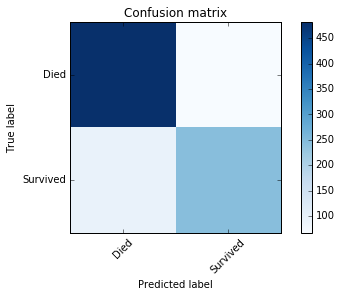

In [18]:
# Logistic Regression

logreg = LogisticRegression()
Y_predLogisticRegression = evaluate_model(logreg, X_train, Y_train, X_test)

# get Correlation Coefficient for each feature using Logistic Regression
coeff_df = DataFrame(X_train.columns.delete(0))
coeff_df.columns = ['Features']
coeff_df["Coefficient Estimate"] = pd.Series(logreg.coef_[0])

# preview
coeff_df

Fold Accuracies: [ 0.65730337  0.71910112  0.73595506  0.75280899  0.76836158]
Accuracy: 0.73 (+/- 0.08 @2std)
Confusion matrix, without normalization
[[441 108]
 [149 191]]


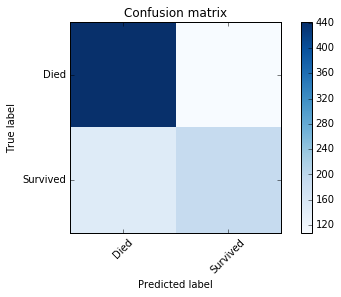

In [19]:
# Support Vector Machines

svc = SVC()
Y_predSVC = evaluate_model(svc, X_train, Y_train, X_test)

Fold Accuracies: [ 0.83146067  0.80898876  0.84831461  0.80337079  0.84745763]
Accuracy: 0.83 (+/- 0.04 @2std)
Confusion matrix, without normalization
[[493  56]
 [ 94 246]]


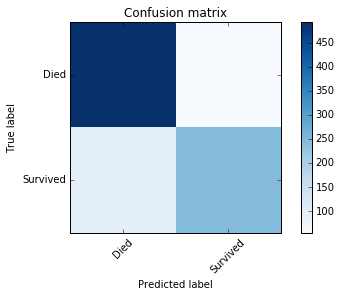

In [20]:
# Random Forests

#random_forest = RandomForestClassifier(n_estimators=100)
random_forest = RandomForestClassifier(criterion='entropy', n_estimators=50, max_depth=8, min_samples_split=8, max_features=5)
Y_predRandomForest = evaluate_model(random_forest, X_train, Y_train, X_test)

#Best: 0.814398 using {'bootstrap': True, 'max_depth': 10, 'min_samples_split': 4, 'criterion': 'gini', 'n_estimators': 50, 'max_features': 2}
#Best: 0.843645 using {'criterion': 'entropy', 'n_estimators': 50, 'max_depth': 8, 'min_samples_split': 8, 'max_features': 5}


Fold Accuracies: [ 0.67977528  0.69662921  0.7247191   0.75280899  0.70621469]
Accuracy: 0.71 (+/- 0.05 @2std)
Confusion matrix, without normalization
[[431 118]
 [156 184]]


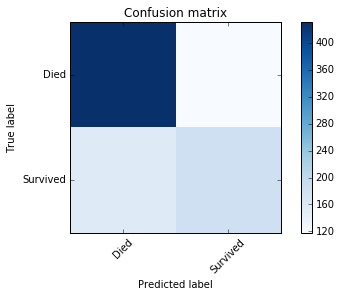

In [21]:
# K Nearest Neighbors

knn = KNeighborsClassifier(n_neighbors = 3)
Y_predKNeighbors = evaluate_model(knn, X_train, Y_train, X_test)

Fold Accuracies: [ 0.76966292  0.81460674  0.79775281  0.76404494  0.85310734]
Accuracy: 0.80 (+/- 0.06 @2std)
Confusion matrix, without normalization
[[468  81]
 [104 236]]


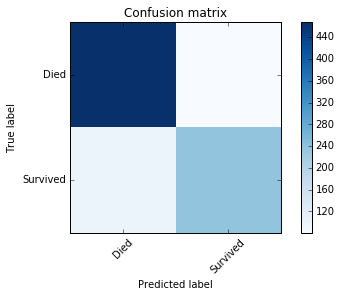

In [22]:
# Gaussian Naive Bayes

gaussian = GaussianNB()
Y_predGaussian = evaluate_model(gaussian, X_train, Y_train, X_test)

## Hyper Parameter Tuning ##
Tuning of Random Forest model.

In [ ]:
from sklearn.grid_search import GridSearchCV
param_grid = { "n_estimators"      : [150, 200, 250],
           "criterion"         : ["gini", "entropy"],
           "max_features"      : [2, 5, 8],
           "max_depth"         : [5, 8, 10],
           "min_samples_split" : [2, 4, 8]}

grid_search = GridSearchCV(random_forest, param_grid, n_jobs=1, cv=StratifiedKFold(Y_train, n_folds=5))
grid_search.fit(X_train, Y_train)

# summarise results
print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_))
for params, mean_score, scores in grid_search.grid_scores_:
    print("%f (%f) with: %r" % (scores.mean(), scores.std(), params))
    
#Best: 0.843645 using {'criterion': 'entropy', 'n_estimators': 50, 'max_depth': 8, 'min_samples_split': 8, 'max_features': 5}


## Create Submission File ##

In [24]:
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": Y_predRandomForest
    })
submission.to_csv('predictions.csv', index=False)